- Prepare the data via cleaning, normalization, encoding categorical variables, etc.
- Generate and evaluate a working linear model
- Enhance your model results by trying different model and/or data enhancement techniques, building 3 models with different regularization and feature engineering techniques
- Evaluate your models using multiple performance metrics and explain your choice of model
- Draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen)
- Use graphs and evidence from the data to prove your conclusions in a form that tells a story that helps the a non-technical person in the business



In this exercise, we will only look at properties with:
- 10 bedrooms or fewer
- 100,000 sqft lot or smaller
- $5M or less

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy
import scipy.stats as ss
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
import statsmodels.stats.power as smsp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import scale
from patsy import dmatrices
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
df = pd.read_csv(url)

df.where((df['bedrooms']<=10), inplace=True)
df.where((df['sqft_lot']<=100000), inplace=True)
df.where((df['price']<=5000000), inplace=True)

df.dropna(inplace=True)

df.drop(['id', 'date'], axis=1, inplace=True)

df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0


In [2]:
#convert some float features to integer

for i in ['price', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
          'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15']:
    df[i] = df[i].astype('int') 
    
    
df.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900,3.0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000,3.0,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [3]:
#calculate mean and standard deviation of the original dataset

price_mean = np.mean(df['price'])
price_stdev = np.std(df['price'])

print('Price Mean :', np.round(price_mean,2))
print('Price Stdev :', np.round(price_stdev,2))

Price Mean : 535286.5
Price Stdev : 352005.32


In [4]:
print(df.describe())

              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.113800e+04  21138.000000  21138.000000  21138.000000  21138.000000   
mean   5.352865e+05      3.367490      2.105213   2060.020721  10329.584114   
std    3.520136e+05      0.905669      0.760701    888.937512  11322.141123   
min    7.500000e+04      0.000000      0.000000    290.000000    520.000000   
25%    3.200000e+05      3.000000      1.500000   1420.000000   5000.000000   
50%    4.499995e+05      3.000000      2.250000   1900.000000   7508.000000   
75%    6.400000e+05      4.000000      2.500000   2520.000000  10317.750000   
max    4.668000e+06     10.000000      7.500000   9640.000000  99916.000000   

             floors    waterfront          view     condition         grade  \
count  21138.000000  21138.000000  21138.000000  21138.000000  21138.000000   
mean       1.492667      0.007427      0.228688      3.411818      7.641309   
std        0.540933      0.085864      0.757312    

### EXPLORATORY DATA ANALYSIS

We will explore the data set using several EDA methods, such as box, hex bin, bar, scatter and facet plots, to find visual patterns, data distribution and interesting observations.

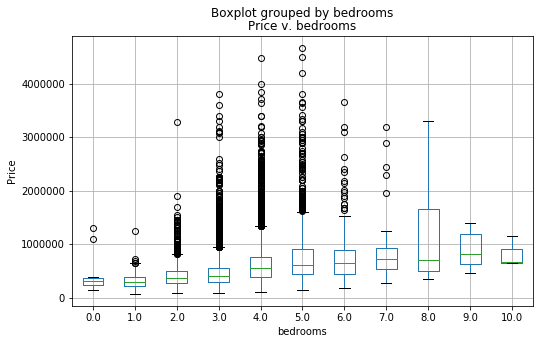

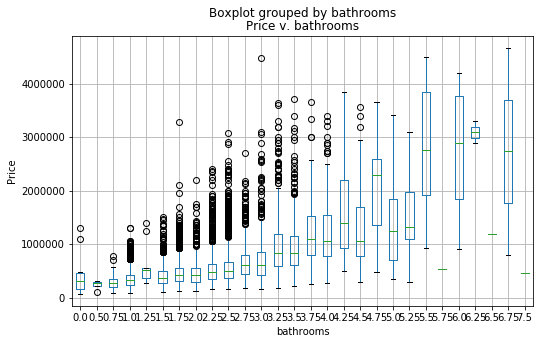

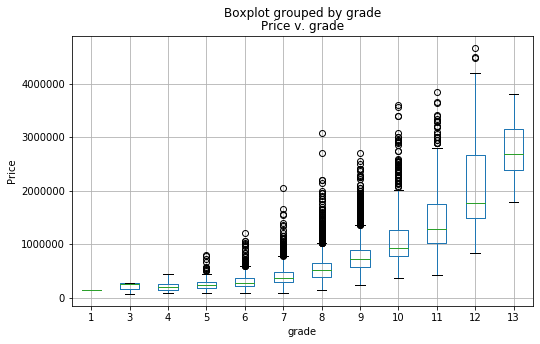

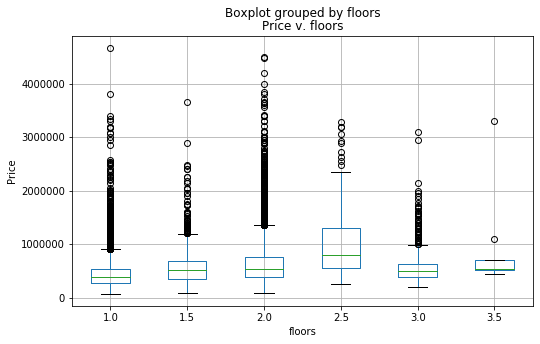

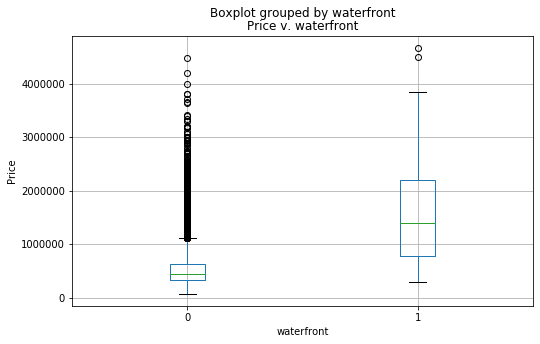

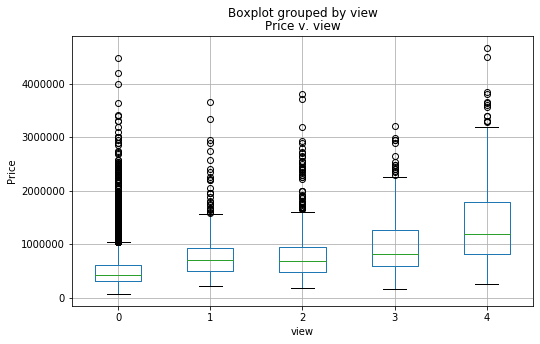

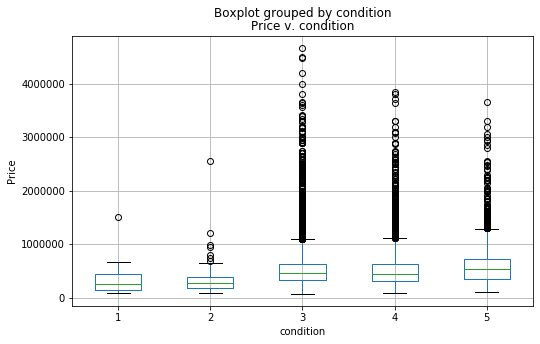

In [5]:
#box plot of feature v. price (label)

for col in ['bedrooms', 'bathrooms', 'grade', 'floors', 'waterfront', 'view', 'condition']:
    fig = plt.figure(figsize=(8, 5))
    ax = fig.gca()
    
    df.boxplot(column = ['price'], by = col, ax = ax)
    ax.set_title('Price v. '+col)
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    plt.show()
    print('\n\n')

Text(0.5, 0, 'Living Sq Ft')

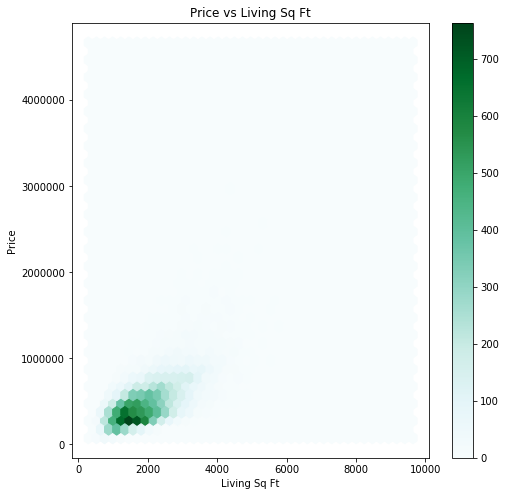

In [6]:
#plotting density (data distribution) of price v living sq ft

ax = plt.figure(figsize=(8,8)).gca()
df.plot.hexbin(x = 'sqft_living', y = 'price', gridsize = 40, ax = ax)
ax.set_title('Price vs Living Sq Ft')
ax.set_ylabel('Price')
ax.set_xlabel('Living Sq Ft')

Text(0.5, 0, 'Year Built')

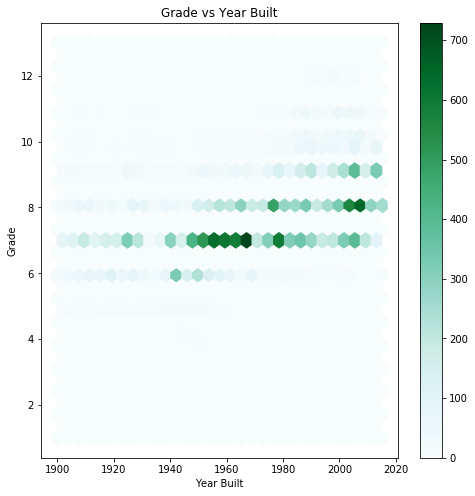

In [7]:
#plotting density (data distribution) of grade v yr_built

ax = plt.figure(figsize=(8,8)).gca()
df.plot.hexbin(x = 'yr_built', y = 'grade', gridsize = 30, ax = ax)
ax.set_title('Grade vs Year Built')
ax.set_ylabel('Grade')
ax.set_xlabel('Year Built')

Top 10 most expensive Zip Code in King County
         med_price_byzip
zipcode                 
98039          1880000.0
98004          1150000.0
98040           993500.0
98112           915000.0
98005           761225.0
98006           760184.5
98119           744975.0
98075           739949.5
98109           736000.0
98102           710000.0


Text(0, 0.5, 'Median Price')

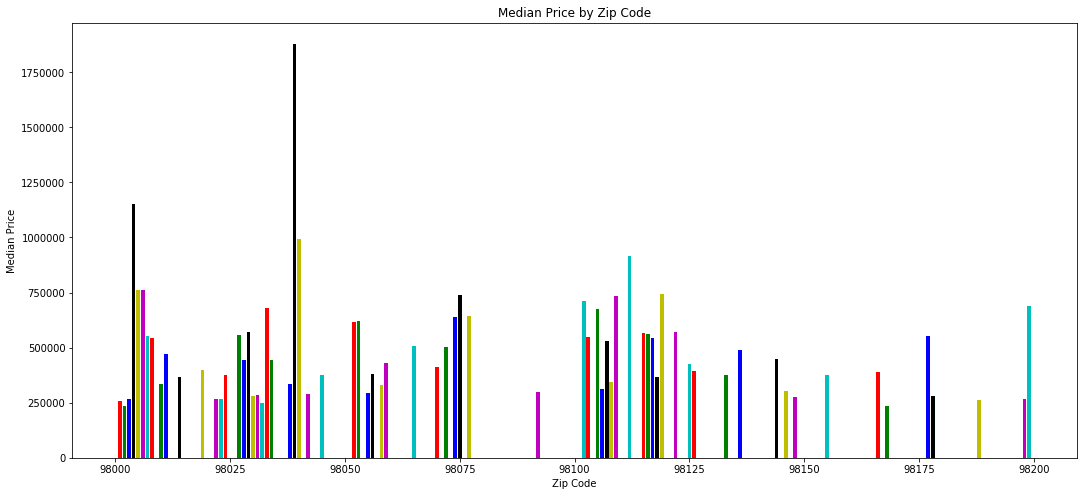

In [8]:
#calculate median price by zip code

med_zip = pd.DataFrame()
med_zip['med_price_byzip'] = df.groupby('zipcode')['price'].median()

print('Top 10 most expensive Zip Code in King County')
print(med_zip.sort_values(by = ['med_price_byzip'], ascending=False).head(10))

plt.figure(figsize=(18,8))
plt.bar(med_zip.index, med_zip['med_price_byzip'], color='rgbkymc')
plt.title('Median Price by Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Median Price')

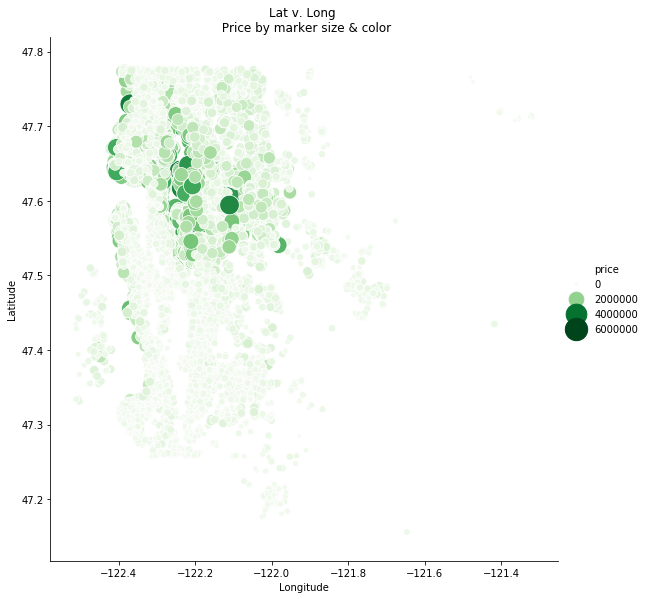

In [9]:
#price by longitude & latitude

ax = sns.relplot(x = 'long', y = 'lat',
                 hue = 'price', palette = 'Greens',
                 size = 'price', sizes = (10.0, 500.0),
                 data = df,
                 height = 8, 
                 aspect = 1/1)
ax.set(title ='Lat v. Long \n Price by marker size & color',
       xlabel = 'Longitude',
       ylabel = 'Latitude')

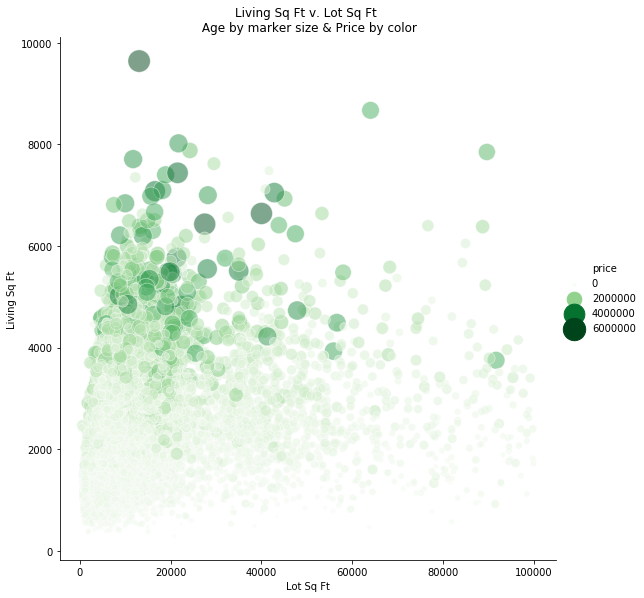

In [10]:
#price by lot and living sqft

ax = sns.relplot(x = 'sqft_lot', y = 'sqft_living',
                 hue = 'price', palette = 'Greens',
                 size = 'price', sizes = (10.0, 500.0),
                 data = df,
                 height = 8, 
                 aspect = 1/1,
                 alpha = 0.5)
ax.set(title ='Living Sq Ft v. Lot Sq Ft \n Age by marker size & Price by color',
       xlabel = 'Lot Sq Ft',
       ylabel = 'Living Sq Ft')

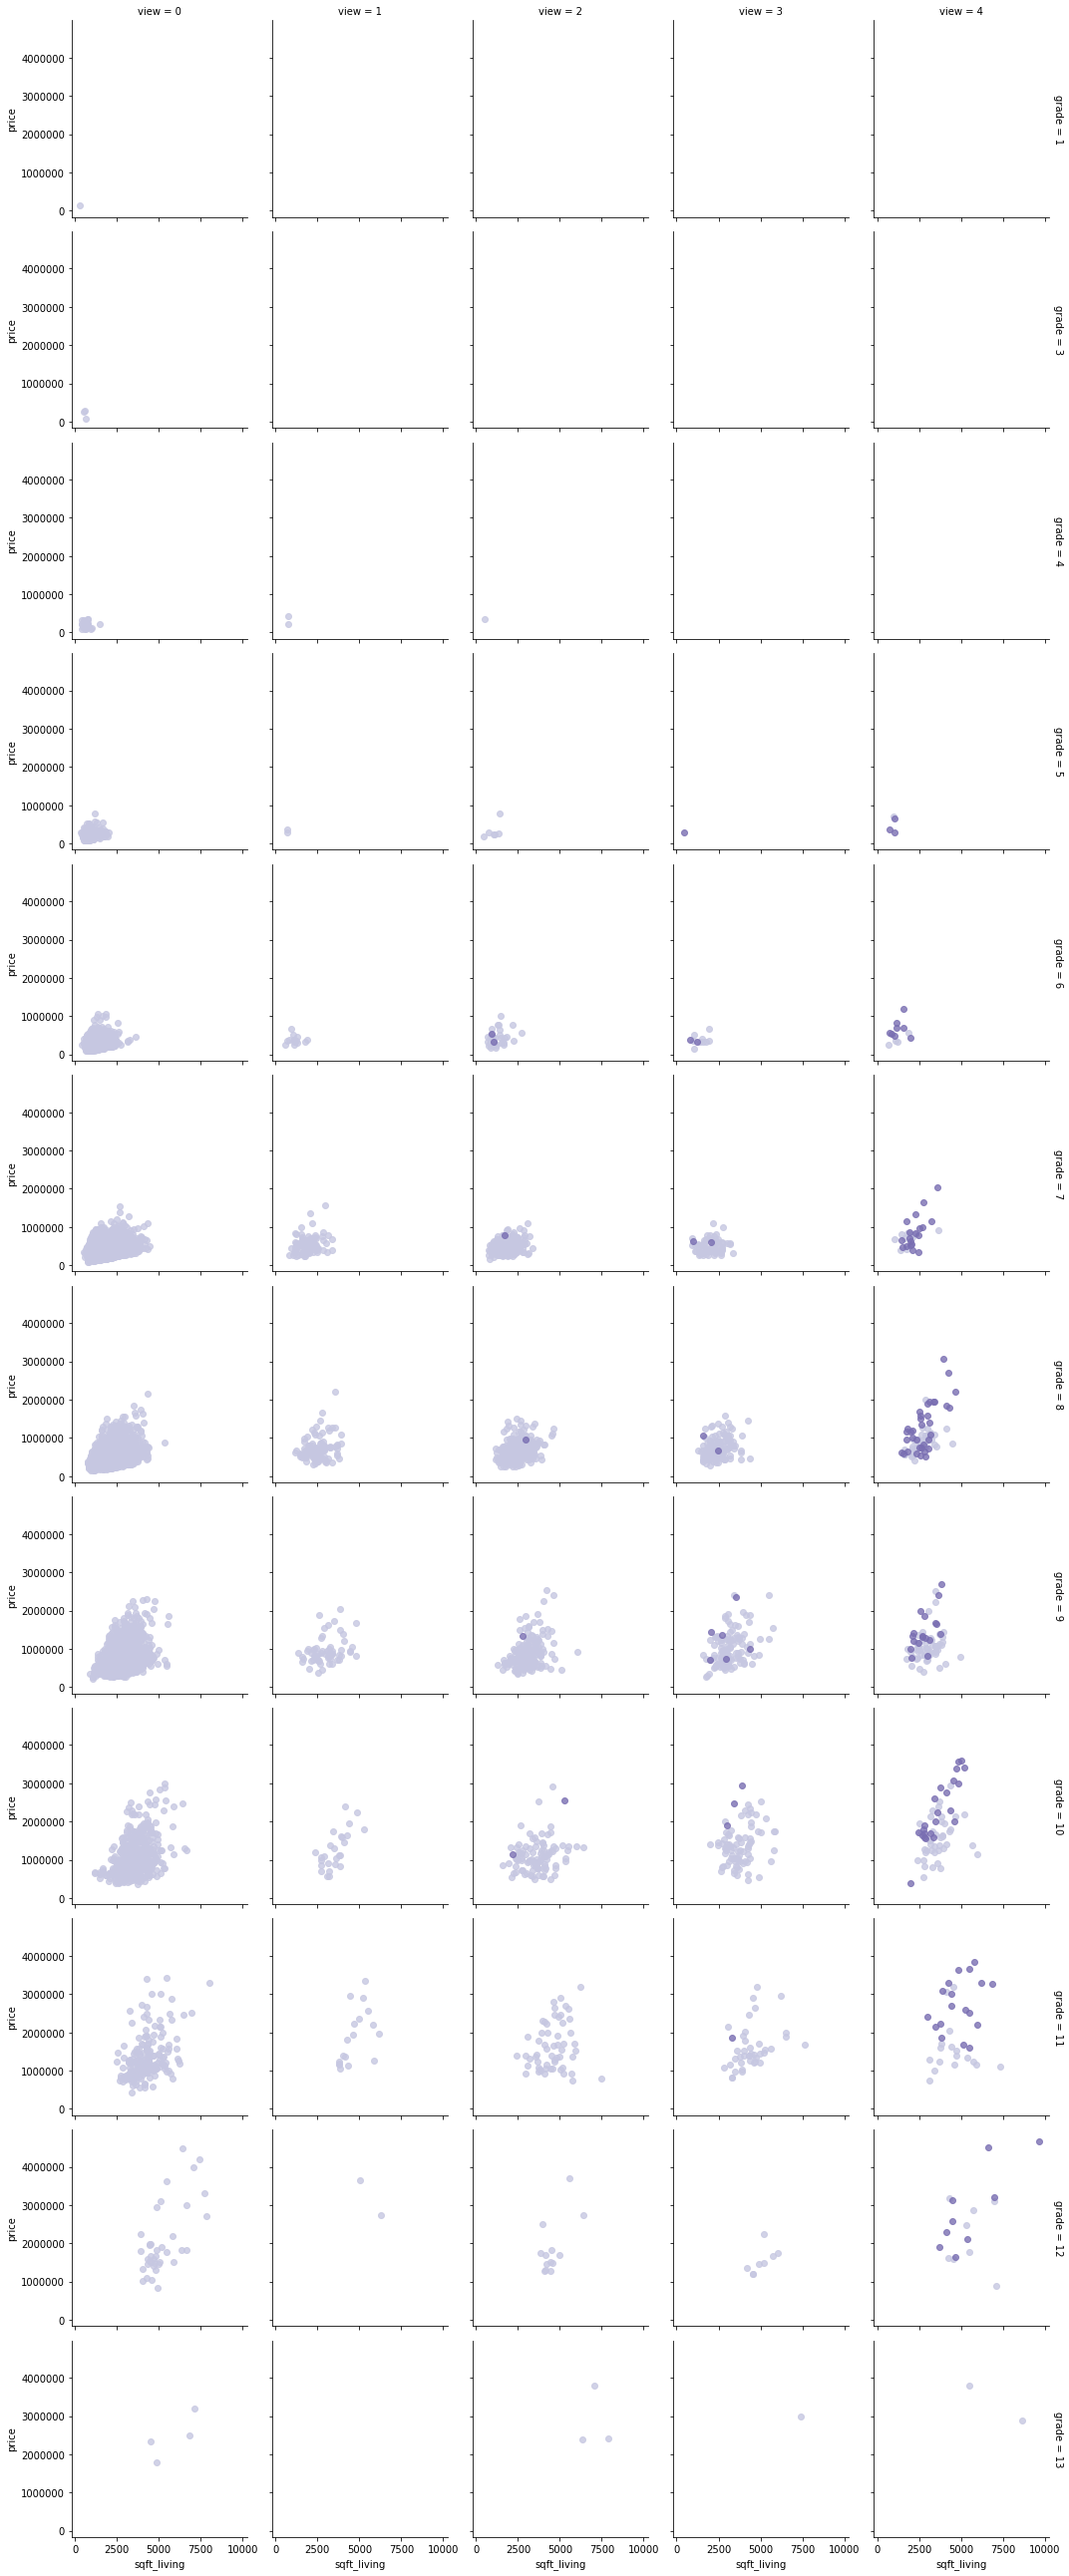

In [11]:
#facet plot for price v. view, grade, waterfront & sqft living

g = sns.FacetGrid(df, col = 'view', 
                  row = 'grade', 
                  hue = 'waterfront', palette="Purples",
                  margin_titles=True)
g.map(sns.regplot, 'sqft_living', 'price', fit_reg = False)

In [12]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [13]:
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()


def residual_plot(df, predicted_col, resids):
    RMSE = np.std(df[resids])
    plt.figure(figsize=[8,4])
    sns.scatterplot(x=predicted_col, y=resids, data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('Plot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()      

### HYPOTHESIS TESTING

Before performing hypothesis testings, we will need to modify some of our features (such as normalization), binning, extra variables, etc. to make runnig the testings easier.

In [14]:
#feature engineering 1


df2 = df.copy(deep=True)

#create a column indicating if the house has a basement or not
df2['basement'] = 0
df2.loc[df['sqft_basement'] > 0, 'basement'] = 1
df2.drop(['sqft_basement'], axis=1, inplace=True)


#convert zipcode to category
for j in ['zipcode']:
    df2[j] = df2[j].astype('category') 
    

#one hot encoding    
#for j in ['basement']:
#    df_ohe = pd.get_dummies(df[j], prefix=j, columns=[j])
#    df2 = pd.concat([df2, df_ohe], axis=1)
#    df2.drop(columns = [j], inplace=True)


#log features 
loglist = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for col in loglist:
    df2.loc[:, col+'_log'] = np.log(df2.loc[:,col])
    df2.drop([col], axis=1, inplace=True)


loglist2 = ['price_log', 'sqft_living_log', 'sqft_lot_log', 
            'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']
    
print(df2.head(2), '\n')

   bedrooms  bathrooms  floors  waterfront  view  condition  grade  yr_built  \
0       3.0       1.00     1.0           0     0          3      7      1955   
1       3.0       2.25     2.0           0     0          3      7      1951   

   yr_renovated zipcode      lat     long  basement  price_log  \
0             0   98178  47.5112 -122.257         0  12.309982   
1          1991   98125  47.7210 -122.319         1  13.195614   

   sqft_living_log  sqft_lot_log  sqft_above_log  sqft_living15_log  \
0         7.073270      8.639411        7.073270           7.200425   
1         7.851661      8.887653        7.682482           7.432484   

   sqft_lot15_log  
0        8.639411  
1        8.941022   



In [15]:
#create grade bins

df3 = df2.copy(deep = True)

nbins = [-1, 3, 6, 9, 13]
nlabels = ['1-3','4-6', '7-9', '>9']

df3.loc[:, 'grade_bin'] = pd.cut(df3.loc[:, 'grade'], bins = nbins, labels = nlabels)


We will explore the summary statistics of log price by grade bin using the classical, bootstrap and bayesian methods.

In [16]:
#classical summary statistics of log price by grade bin

grd_bin = ['1-3', '4-6', '7-9', '>9']

idx1 = ['mean', 'std_err', 'ci_lower', 'ci_upper']

grd_sum_stats = pd.DataFrame(columns = grd_bin, index=idx1)

for a in grd_bin:
    grd_sum_stats.loc['mean'][a] = round(df3[df3['grade_bin']==a]['price_log'].mean(),2)
    grd_sum_stats.loc['std_err'][a] = round(ss.sem(df3[df3['grade_bin']==a]['price_log']),2)
    grd_sum_stats.loc['ci_lower'][a] = round(grd_sum_stats.loc['mean'][a] - 1.96 * grd_sum_stats.loc['std_err'][a],2)
    grd_sum_stats.loc['ci_upper'][a] = round(grd_sum_stats.loc['mean'][a] + 1.96 * grd_sum_stats.loc['std_err'][a],2)
    
print('Classical Summary Statistics for Log Price by Grade - 95% CI')
grd_sum_stats.head()

Classical Summary Statistics for Log Price by Grade - 95% CI


,1-3,4-6,7-9,>9
mean,12.03,12.51,13.03,13.93
std_err,0.31,0.01,0,0.01
ci_lower,11.42,12.49,13.03,13.91
ci_upper,12.64,12.53,13.03,13.95


In [17]:
#bootstrap sample & summary statistics of log price by grade bin

n_replicas = 1000
grd_sample_mean_boot = pd.DataFrame(columns = grd_bin, index=range(n_replicas))
idx2 = ['mean', 'ci_lower', 'ci_upper']


for i in range(n_replicas):
    sample = df3.sample(frac=1.0, replace=True)
    sample.dropna(inplace=True)
    
    for b in grd_bin:
        grd_sample_mean_boot.loc[i][b] = sample[sample['grade_bin']==b]['price_log'].mean()
        
        
grd_sum_stats_boot = pd.DataFrame(columns = grd_bin, index=idx2)

for a in grd_bin:
    grd_sum_stats_boot.loc['mean'][a] = round(grd_sample_mean_boot[a].mean(),2)
    grd_sum_stats_boot.loc['ci_lower'][a] = round(np.percentile(grd_sample_mean_boot[a],5/2),2)
    grd_sum_stats_boot.loc['ci_upper'][a] = round(np.percentile(grd_sample_mean_boot[a],100-5/2),2)


print('Bootstrap Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats_boot.head(),'\n')

Bootstrap Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.02  12.51  13.03  13.93
ci_lower  11.23   12.5  13.03  13.91
ci_upper  12.54  12.53  13.04  13.95 



In [18]:
def plot_hist(x, xmin, xmax, p=5, nbins=20):
    # Plot the distribution and mark the mean
    plt.hist(x, bins=nbins, alpha=.5)
    x_mean = x.mean() 
    plt.axvline(x_mean, color='orange')
    print('Point estimate of the mean = %6.2f' %x_mean)
    # 95% confidence interval  
    upper_ci = np.percentile(x, 100-p/2.)
    lower_ci = np.percentile(x, p/2.)
    plt.axvline(upper_ci, color='red', linewidth=3)
    plt.axvline(lower_ci, color='red', linewidth=3)
    print('The lower and upper confidence intervals = %6.2f %6.2f' %(lower_ci, upper_ci))
    plt.xlim(xmin, xmax)

Point estimate of the mean =  12.02
The lower and upper confidence intervals =  11.23  12.54


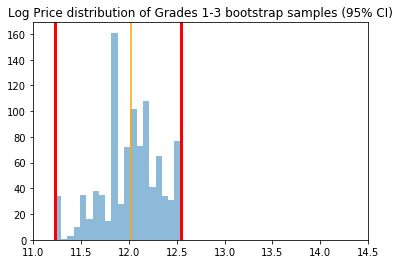



Point estimate of the mean =  12.51
The lower and upper confidence intervals =  12.50  12.53


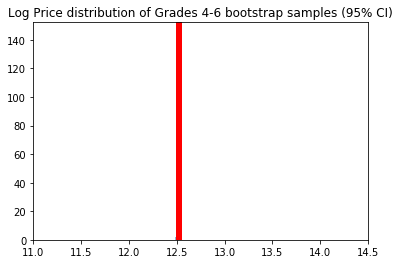



Point estimate of the mean =  13.03
The lower and upper confidence intervals =  13.03  13.04


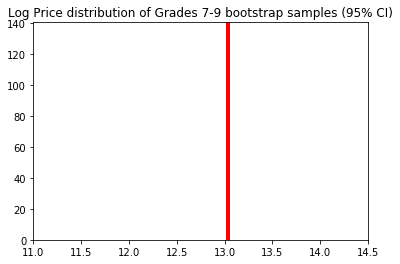



Point estimate of the mean =  13.93
The lower and upper confidence intervals =  13.91  13.95


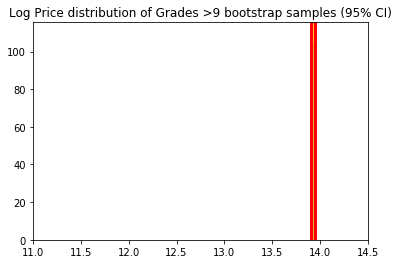

In [19]:
#plot distribution of bootstrap samples

for j in grd_bin:
    plot_hist(grd_sample_mean_boot[j], grd_sample_mean_boot[j].min(), grd_sample_mean_boot[j].max())
    plt.title('Log Price distribution of Grades ' + j + ' bootstrap samples (95% CI)')
    plt.xlim(11,14.5)
    plt.show()
    print('\n')

In [20]:
def comp_like(p, x): 
    variance = np.std(x)**2
    x_mean = np.asarray(x).mean()
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return (l/l.sum(), round(x_mean,2), np.std(x))


def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity


def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')

    print('The %.3f credible interval is %.3f to %.3f' % (interval, ci[0], ci[1]))
    
    return round(ci[0],2), round(ci[1],2)


Mean = 12.027, Standard deviation = 0.533


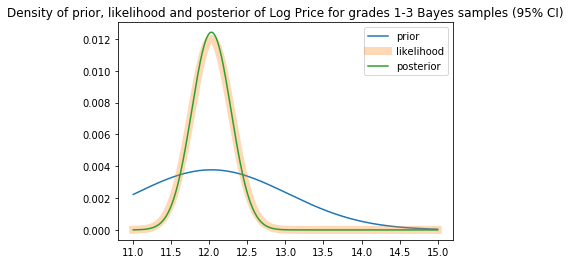

Mean = 12.027, Standard deviation = 0.533
The 0.950 credible interval is 11.501 to 12.519


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.percentile is deprecated and will be removed in SciPy 2.0.0, use numpy.percentile instead


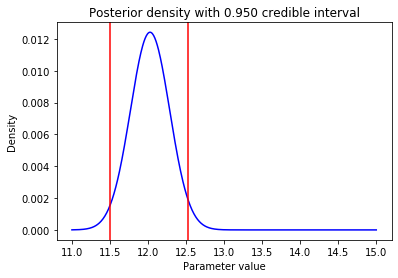



Mean = 12.513, Standard deviation = 0.399


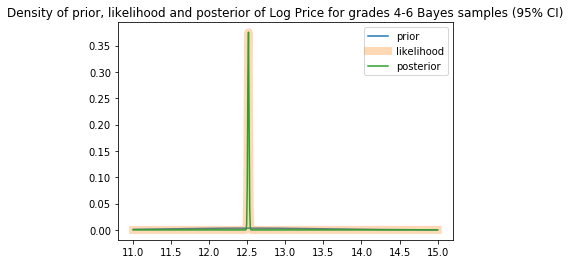

Mean = 12.513, Standard deviation = 0.399
The 0.950 credible interval is 12.499 to 12.531


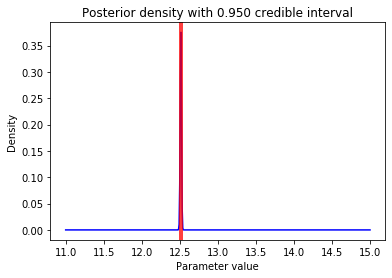



Mean = 13.032, Standard deviation = 0.437


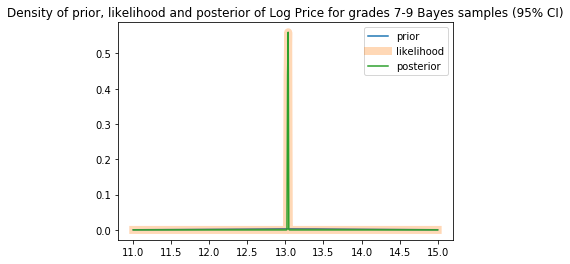

Mean = 13.032, Standard deviation = 0.437
The 0.950 credible interval is 13.028 to 13.036


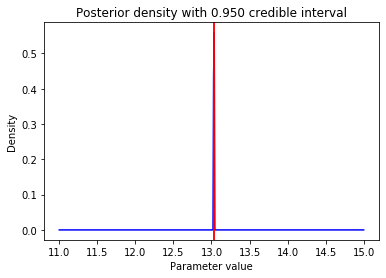



Mean = 13.928, Standard deviation = 0.444


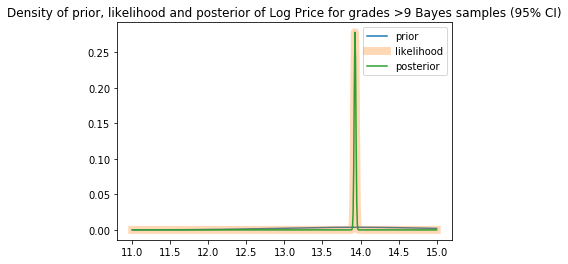

Mean = 13.928, Standard deviation = 0.444
The 0.950 credible interval is 13.910 to 13.950


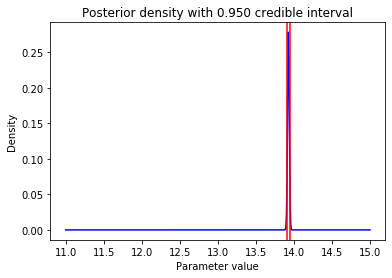



Bayesian statistics for Grade


,1-3,4-6,7-9,>9
mean,12.03,12.51,13.03,13.93
ci_lower,11.5,12.5,13.03,13.91
ci_upper,12.52,12.53,13.04,13.95


In [21]:
#bayes sample & summary statistics of log price by grade_bin

N = 500
p =  np.linspace(11, 15, num=N)

lower_q = 2.5/100
upper_q = 97.5/100

idx3 = ['pp', 'like', 'post', 'mean', 'ci_lower', 'ci_upper']

grd_bayes = pd.DataFrame(columns = grd_bin, index = idx3)

for a in grd_bin:
    grd_bayes.loc['pp'][a] = ss.norm.pdf(p, loc=df3[df3['grade_bin']==a]['price_log'].mean()) / (ss.norm.pdf(p, loc=df3[df3['grade_bin']==a]['price_log'].mean())).sum()
    grd_bayes.loc['like'][a] = comp_like(p, df3[df3['grade_bin']==a]['price_log'])[0]
    grd_bayes.loc['post'][a] = posterior(grd_bayes.loc['pp'][a], grd_bayes.loc['like'][a])

    plt.plot(p, grd_bayes.loc['pp'][a], label='prior')
    plt.plot(p, grd_bayes.loc['like'][a], label='likelihood', alpha=.3, linewidth=8)
    plt.plot(p, grd_bayes.loc['post'][a], label='posterior')
    _=plt.legend()
    plt.title('Density of prior, likelihood and posterior of Log Price for grades ' + a + ' Bayes samples (95% CI)')
    plt.show()
    
    grd_bayes.loc['mean'][a] = round(comp_like(p, df3[df3['grade_bin']==a]['price_log'])[1],2)
    grd_bayes.loc['ci_lower'][a], grd_bayes.loc['ci_upper'][a] = plot_ci(p, grd_bayes.loc['post'][a], N, lower_q, upper_q)
    plt.show()
    print('\n')

print('Bayesian statistics for Grade')
grd_bayes.loc[['mean', 'ci_lower', 'ci_upper']]

In [22]:
#grade bin statistics: classic, botostrap & bayesian

print('Classical Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats)

print('\nBootstrap Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats_boot)

print('\nBayesian Summary Statistics for Log Price by Grade - 95% CI')
print(grd_bayes.loc[['mean', 'ci_lower', 'ci_upper']])

Classical Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.03  12.51  13.03  13.93
std_err    0.31   0.01      0   0.01
ci_lower  11.42  12.49  13.03  13.91
ci_upper  12.64  12.53  13.03  13.95

Bootstrap Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.02  12.51  13.03  13.93
ci_lower  11.23   12.5  13.03  13.91
ci_upper  12.54  12.53  13.04  13.95

Bayesian Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.03  12.51  13.03  13.93
ci_lower   11.5   12.5  13.03  13.91
ci_upper  12.52  12.53  13.04  13.95


Analyzing the summary statistic results above, we notice that all three methods show that the difference of mean price between grade bins 1-3 and 4-6 houses are not statistically significant. However, houses with grade bins 7-9 and >9 have statistically different average price. We will perform ANOVA and Tukey HSD tests as well (below).

In [23]:
#anova of log price based on grade bin

f_statistic_grd, p_value_grd = ss.f_oneway(df3[df3['grade_bin']=='1-3']['price_log'], df3[df3['grade_bin']=='4-6']['price_log'],
                                         df3[df3['grade_bin']=='7-9']['price_log'], df3[df3['grade_bin']=='>9']['price_log'])

print('F statistic = ' + str(f_statistic_grd))
print('P-value = ' + str(p_value_grd))

F statistic = 3260.497582926536
P-value = 0.0


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1-3    4-6   0.4865 0.1124 -0.0712 1.0443  False
   1-3    7-9   1.0055  0.001  0.4482 1.5628   True
   1-3     >9   1.9007  0.001  1.3427 2.4586   True
   4-6    7-9    0.519  0.001  0.4941 0.5439   True
   4-6     >9   1.4141  0.001  1.3773  1.451   True
   7-9     >9   0.8951  0.001  0.8654 0.9248   True
---------------------------------------------------


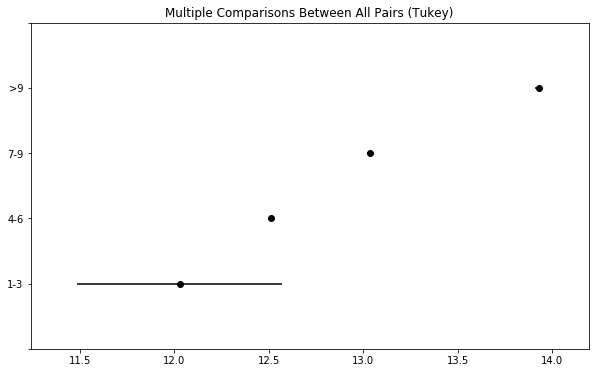

In [24]:
#tukey's hsd of log price based on grade bin

Tukey_HSD = pairwise_tukeyhsd(df3['price_log'], df3['grade_bin'])
print(Tukey_HSD)

_ = Tukey_HSD.plot_simultaneous()

Based on our classical ANOVA test, we see that we can reject the H_null that house price does not depend on the grade of the house (small p-value, large F-statistic). 

Using Tukey's HSD, we see that the prices of houses with grades 1-3 and 4-6 are not significantly different. However prices for houses with other grades are  significantly different from each other.

### BASIC LINEAR MODEL

As the first step of our modeling exercise, we will perform ordinary least squares linear regression to predict the sale price using all the available features (no trimming or prunning). We will scale the features to prevent some features dominate smaller features.

In [25]:
#scale features

df_scaled0 = df.copy(deep=True)

for col in df.drop(['price'], axis=1).columns:
    df_scaled0.loc[:,col] = scale(df.loc[:,col])

In [26]:
#basic ols

form0 = 'price ~ zipcode + bedrooms + bathrooms + floors + view + waterfront + condition + grade + yr_built + yr_renovated + lat + long + sqft_living + sqft_lot + sqft_above + sqft_basement + sqft_living15 + sqft_lot15'

collist0 = df_scaled0.columns.drop(['price'])

ols_model_0 = smf.ols(formula = form0, data = df_scaled0).fit()

df_scaled0['predicted_price_ols'] = ols_model_0.predict(df_scaled0[collist0])

print(ols_model_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     3000.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:33:34   Log-Likelihood:            -2.8697e+05
No. Observations:               21138   AIC:                         5.740e+05
Df Residuals:                   21120   BIC:                         5.741e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.353e+05   1310.719    408.391

In [27]:
df_scaled0['resids_ols'] = np.subtract(df_scaled0['predicted_price_ols'], df_scaled0['price'])

df_scaled0[['price', 'predicted_price_ols', 'resids_ols']].head(3)

,price,predicted_price_ols,resids_ols
0,221900,216442.836812,-5457.163188
1,538000,722620.008528,184620.008528
2,180000,399165.881717,219165.881717


Mean of predicted values = 535287.0
STD of predicted values = 296013.0



Text(0.5, 0, 'Price')

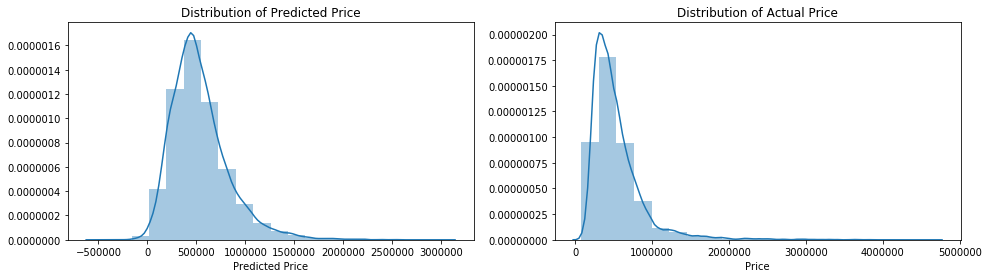

In [28]:
#plot predicted & actual price distributions

xmin = min(min(df_scaled0['predicted_price_ols']), min(df_scaled0['price']))
xmax = max(max(df_scaled0['predicted_price_ols']), max(df_scaled0['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled0['predicted_price_ols'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled0['predicted_price_ols'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled0['predicted_price_ols'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled0['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

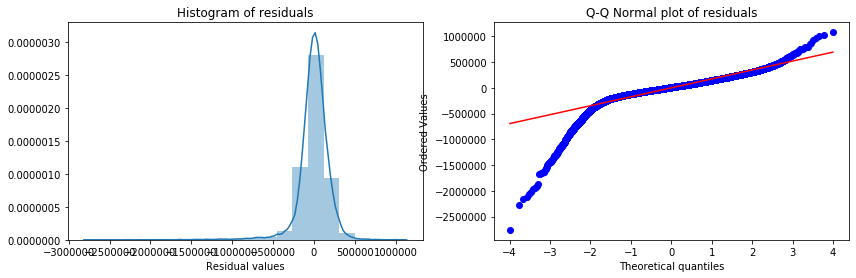

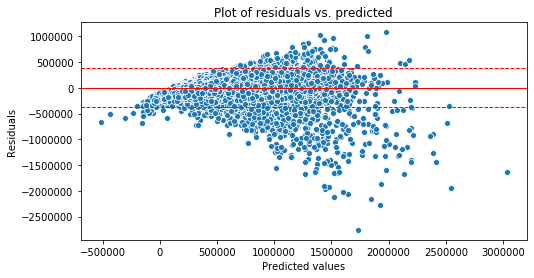

In [29]:
#plot residuals distribution

plot_resid_dist(df_scaled0['resids_ols'])

residual_plot(df_scaled0, 'predicted_price_ols', 'resids_ols')

In [30]:
#calculate metrics

ssr0 = sum((df_scaled0['price']-df_scaled0['predicted_price_ols'])**2)       
sst0 = sum((df_scaled0['price']-np.mean(df_scaled0['price']))**2)    

r_squared0 = 1 - (float(ssr0))/sst0
adjusted_r_squared0 = 1 - (1-r_squared0)*(len(df_scaled0['price'])-1)/(len(df_scaled0['price'])-df_scaled0[collist0].shape[1]-1)

rmse0 = round(np.sqrt(mean_squared_error(df_scaled0['price'], df_scaled0['predicted_price_ols'])),2)

print('R-Squared: ', np.round(r_squared0,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared0,3))
print('RMSE: ', rmse0)

R-Squared:  0.707
Adj R-Squared:  0.707
RMSE:  190483.17


Analyzing the results, we determine that our model has:
- Adjusted R-square = 0.707
- RMSE: 190,483
- Predicted Mean = 535,287 (v. Actual Mean: 535,286)
- Predicted Standard Dev = 296,013 (v. Actual Standard Dev: 352,005)

### REGULARIZATION & MODELING

In [31]:
#feature engineering 2

#remove features that are correlated

#sqft above is correlated to sqft living
df2.drop(['sqft_above_log'], axis=1, inplace=True)

#lat & long are correlated to zipcode
df2.drop(['lat', 'long'], axis=1, inplace=True)

In [32]:
#scaling values

df_scaled = df2.copy(deep=True)

scalelist = df_scaled.drop(['price_log', 'zipcode'], axis=1).columns

for col in scalelist:
    df_scaled.loc[:,col] = scale(df2.loc[:,col])


print(df_scaled.head(3))

   bedrooms  bathrooms    floors  waterfront     view  condition     grade  \
0 -0.405776  -1.452923 -0.910795   -0.086504 -0.30198  -0.632105 -0.552376   
1 -0.405776   0.190338  0.937907   -0.086504 -0.30198  -0.632105 -0.552376   
2 -1.509958  -1.452923 -0.910795   -0.086504 -0.30198  -0.632105 -1.413702   

   yr_built  yr_renovated zipcode  basement  price_log  sqft_living_log  \
0 -0.535336     -0.209032   98178 -0.807417  12.309982        -1.116705   
1 -0.671131      4.771135   98125  1.238517  13.195614         0.734066   
2 -1.282207     -0.209032   98028 -0.807417  12.100712        -2.131689   

   sqft_lot_log  sqft_living15_log  sqft_lot15_log  
0     -0.362505          -1.023034       -0.371027  
1     -0.040019          -0.312298        0.050674  
2      0.379177           1.145271        0.126027  


In [33]:
#formula

form1 = 'price_log ~ bedrooms + bathrooms + floors + view + waterfront + condition + grade + yr_built + yr_renovated + zipcode + basement + sqft_living_log + sqft_lot_log + sqft_living15_log + sqft_lot15_log'

#without intercept (add -1 at the end)
form2 = 'price_log ~ bedrooms + bathrooms + floors + view + waterfront + condition + grade + yr_built + yr_renovated + zipcode + basement + sqft_living_log + sqft_lot_log + sqft_living15_log + sqft_lot15_log - 1'


In [34]:
collist1 = df_scaled.columns.drop(['price_log'])

collist2 = collist1.drop('zipcode')

#### OLS with Feature Engineering

In [35]:
#ols with engineered features

df_scaled1 = df_scaled.copy(deep=True)

ols_model_1 = smf.ols(formula = form1, data = df_scaled1).fit()

df_scaled1['predicted_price_ols'] = ols_model_1.predict(df_scaled1[collist1])

print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1927.
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:33:36   Log-Likelihood:                 6380.4
No. Observations:               21138   AIC:                        -1.259e+04
Df Residuals:                   21054   BIC:                        -1.192e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.5518      0.01

In [36]:
df_scaled1['price'] = np.exp(df_scaled1['price_log'])

df_scaled1['predicted_price_ols_unlogged'] = np.exp(df_scaled1['predicted_price_ols'])

df_scaled1['resids_ols'] = np.subtract(df_scaled1['predicted_price_ols_unlogged'], df_scaled1['price'])

df_scaled1[['price', 'predicted_price_ols_unlogged', 'resids_ols']].head()

,price,predicted_price_ols_unlogged,resids_ols
0,221900.0,230010.319269,8110.319269
1,538000.0,537313.060915,-686.939085
2,180000.0,267166.298153,87166.298153
3,604000.0,545457.715427,-58542.284573
4,510000.0,473179.016492,-36820.983508


Mean of predicted values = 525610.0
STD of predicted values = 314919.0



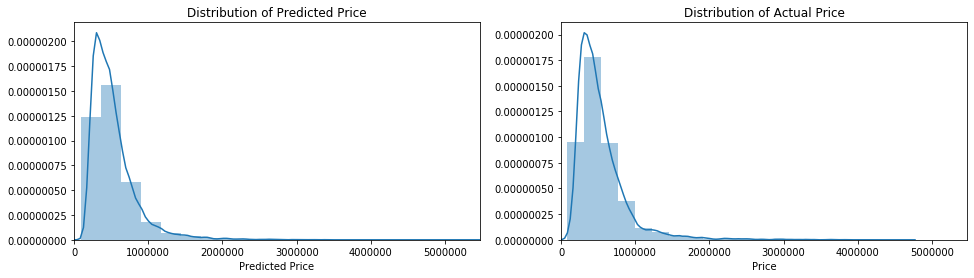

In [37]:
#plot predicted & actual price distributions

xmin = min(min(df_scaled1['predicted_price_ols_unlogged']), min(df_scaled1['price']))
xmax = max(max(df_scaled1['predicted_price_ols_unlogged']), max(df_scaled1['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled1['predicted_price_ols_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled1['predicted_price_ols_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled1['predicted_price_ols_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled1['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
_=ax[1].set_xlim(0,xmax)

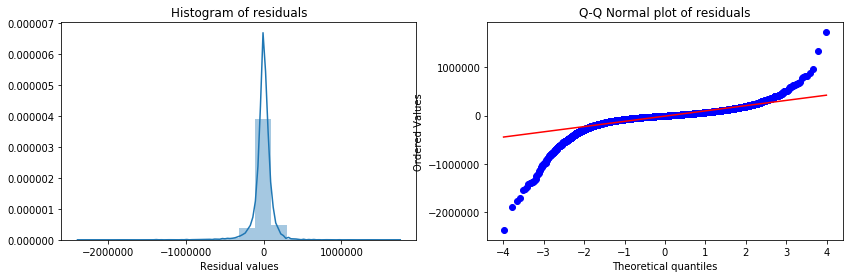

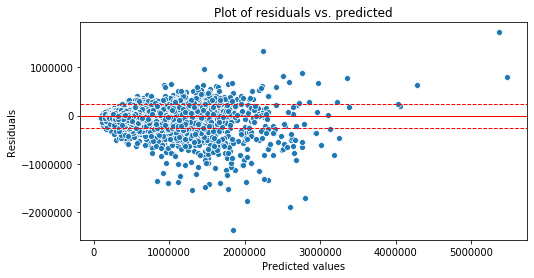

In [38]:
#plot residuals distribution

plot_resid_dist(df_scaled1['resids_ols'])

residual_plot(df_scaled1, 'predicted_price_ols_unlogged', 'resids_ols')

In [39]:
#calculate metrics

ssr1 = sum((df_scaled1['price_log']-df_scaled1['predicted_price_ols'])**2)       
sst1 = sum((df_scaled1['price_log']-np.mean(df_scaled1['price_log']))**2)    

r_squared1 = 1 - (float(ssr1))/sst1
adjusted_r_squared1 = 1 - (1-r_squared1)*(len(df_scaled1['price_log'])-1)/(len(df_scaled1['price_log'])-df_scaled1[collist1].shape[1]-1)

rmse1 = round(np.sqrt(mean_squared_error(df_scaled1['price'], df_scaled1['predicted_price_ols_unlogged'])),2)

print('R-Squared: ', np.round(r_squared1,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared1,3))
print('RMSE: ', rmse1)

R-Squared:  0.884
Adj R-Squared:  0.884
RMSE:  124633.66


Analyzing the results, we determine that our model has:
- Adjusted R-square = 0.884
- RMSE: 124,633
- Predicted Mean = 525,610 (v. Actual Mean: 535,286)
- Predicted Standard Dev = 314,919 (v. Actual Standard Dev: 352,005)

#### Linear Model with Ridge Regression

In [40]:
#ridge regression

'''
df_scaled2 = df_scaled.copy(deep=True)

y2, X2 = dmatrices(form2, data=df_scaled2)

for j in ['zipcode']:
    df_ohe = pd.get_dummies(df_scaled2[j], prefix=j, columns=[j])
    df_scaled2 = pd.concat([df_ohe, df_scaled2], axis=1)
    df_scaled2.drop(columns = [j], inplace=True)
        
ols_model_ridge = sm.OLS(y2, X2).fit_regularized(method = 'elastic_net', alpha=0.0001, L1_wt=0.0)
'''

"\ndf_scaled2 = df_scaled.copy(deep=True)\n\ny2, X2 = dmatrices(form2, data=df_scaled2)\n\nfor j in ['zipcode']:\n    df_ohe = pd.get_dummies(df_scaled2[j], prefix=j, columns=[j])\n    df_scaled2 = pd.concat([df_ohe, df_scaled2], axis=1)\n    df_scaled2.drop(columns = [j], inplace=True)\n        \nols_model_ridge = sm.OLS(y2, X2).fit_regularized(method = 'elastic_net', alpha=0.0001, L1_wt=0.0)\n"

In [41]:
df_scaled2 = df_scaled.copy(deep=True)

ols_model_ridge = smf.ols(form1, data=df_scaled2).fit_regularized(alpha=0.0001,L1_wt=0.0)

df_scaled2['predicted_price_ridge'] = ols_model_ridge.predict(df_scaled2.drop(['price_log'], axis = 1))

print(df_scaled2[['price_log', 'predicted_price_ridge']])

       price_log  predicted_price_ridge
0      12.309982              12.345553
1      13.195614              13.193350
2      12.100712              12.497473
3      13.311329              13.200883
4      13.142166              13.062766
...          ...                    ...
21608  12.793859              13.200086
21609  12.899220              12.907437
21610  12.904459              12.674155
21611  12.899220              12.942560
21612  12.691580              12.668616

[21138 rows x 2 columns]


In [42]:
df_scaled2['price'] = np.exp(df_scaled2['price_log'])

df_scaled2['predicted_price_ridge_unlogged'] = np.exp(df_scaled2['predicted_price_ridge'])

df_scaled2['resids_ridge'] = np.subtract(df_scaled2['predicted_price_ridge_unlogged'], df_scaled2['price'])

df_scaled2[['price', 'predicted_price_ridge_unlogged', 'resids_ridge']].head()

,price,predicted_price_ridge_unlogged,resids_ridge
0,221900.0,229935.174471,8035.174471
1,538000.0,536783.240511,-1216.759489
2,180000.0,267659.938058,87659.938058
3,604000.0,540842.541370,-63157.458630
4,510000.0,471071.738394,-38928.261606


Mean of predicted values = 524243.0
STD of predicted values = 312401.0



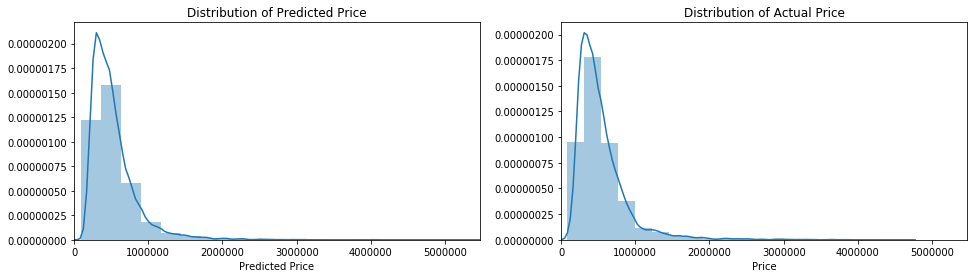

In [43]:
#plot predicted & actual price distributions

xmin = min(min(df_scaled2['predicted_price_ridge_unlogged']), min(df_scaled2['price']))
xmax = max(max(df_scaled2['predicted_price_ridge_unlogged']), max(df_scaled2['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled2['predicted_price_ridge_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled2['predicted_price_ridge_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled2['predicted_price_ridge_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled2['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
_=ax[1].set_xlim(0,xmax)

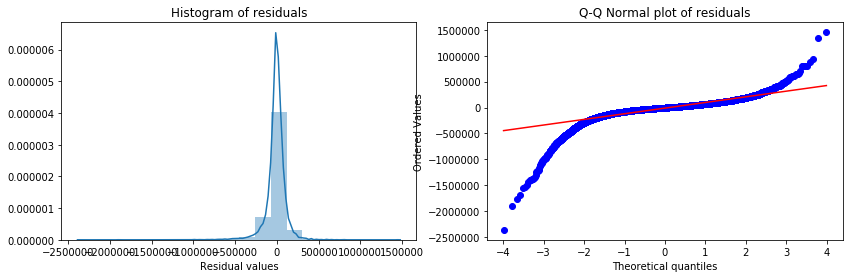

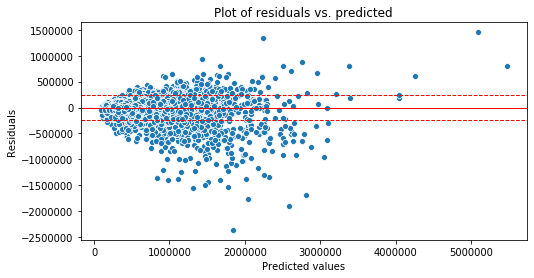

In [44]:
#plot residuals distribution

plot_resid_dist(df_scaled2['resids_ridge'])

residual_plot(df_scaled2, 'predicted_price_ridge_unlogged', 'resids_ridge')

In [45]:
#calculate metrics

ssr2 = sum((df_scaled2['price_log']-df_scaled2['predicted_price_ridge'])**2)       
sst2 = sum((df_scaled2['price_log']-np.mean(df_scaled2['price_log']))**2)    

r_squared2 = 1 - (float(ssr2))/sst2
adjusted_r_squared2 = 1 - (1-r_squared2)*(len(df_scaled2['price_log'])-1)/(len(df_scaled2['price_log'])-df_scaled2[collist2].shape[1]-1)

rmse2 = round(np.sqrt(mean_squared_error(df_scaled2['price'], df_scaled2['predicted_price_ridge_unlogged'])),2)

print('R-Squared: ', np.round(r_squared2,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared2,3))
print('RMSE: ', rmse2)

R-Squared:  0.883
Adj R-Squared:  0.883
RMSE:  125009.37


Analyzing the results, we determine that our model has:
- Adjusted R-square = 0.883
- RMSE: 125,009
- Predicted Mean = 524,243 (v. Actual Mean: 535,286)
- Predicted Standard Dev = 312,401 (v. Actual Standard Dev: 352,005)

#### Linear Model with Lasso Regression

In [46]:
#lasso regression

df_scaled3 = df_scaled.copy(deep=True)

y3, X3 = dmatrices(form2, data=df_scaled3)

for j in ['zipcode']:
    df_ohe = pd.get_dummies(df_scaled3[j], prefix=j, columns=[j])
    df_scaled3 = pd.concat([df_ohe, df_scaled3], axis=1)
    df_scaled3.drop(columns = [j], inplace=True)
        
ols_model_lasso = sm.OLS(y3, X3).fit_regularized(method = 'elastic_net', alpha=0.001, L1_wt=1.0)

In [47]:
#df_scaled3 = df_scaled.copy(deep=True)

#ols_model_lasso = smf.ols(form2, data=df_scaled3).fit_regularized(alpha=0.001,L1_wt=1.0)

df_scaled3['predicted_price_lasso'] = ols_model_lasso.predict(df_scaled3.drop(['price_log'], axis=1))

print(df_scaled3[['price_log', 'predicted_price_lasso']])

       price_log  predicted_price_lasso
0      12.309982              12.249756
1      13.195614              13.167439
2      12.100712              12.423336
3      13.311329              13.121950
4      13.142166              13.001274
...          ...                    ...
21608  12.793859              13.164099
21609  12.899220              12.827259
21610  12.904459              12.619987
21611  12.899220              12.842636
21612  12.691580              12.604181

[21138 rows x 2 columns]


In [48]:
df_scaled3['predicted_price_lasso_unlogged'] = np.exp(df_scaled3['predicted_price_lasso'])

df_scaled3['price'] = np.exp(df_scaled3['price_log'])

df_scaled3['resids_lasso'] = np.subtract(df_scaled3['predicted_price_lasso_unlogged'], df_scaled3['price'])

df_scaled3[['price', 'predicted_price_lasso_unlogged', 'resids_lasso']].head()

,price,predicted_price_lasso_unlogged,resids_lasso
0,221900.0,208930.271237,-12969.728763
1,538000.0,523053.232777,-14946.767223
2,180000.0,248534.143252,68534.143252
3,604000.0,499793.345067,-104206.654933
4,510000.0,442977.433397,-67022.566603


Mean of predicted values = 489629.0
STD of predicted values = 288020.0



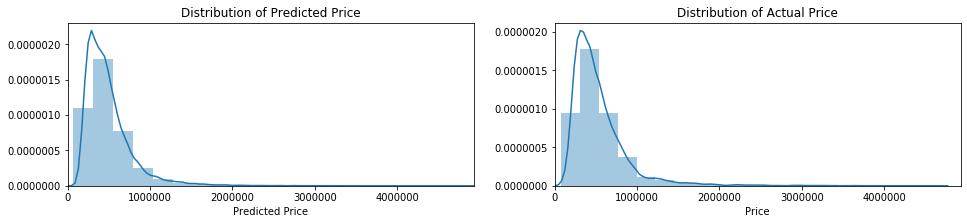

In [49]:
#plot predicted & actual price distributions

xmin = min(min(df_scaled3['predicted_price_lasso_unlogged']), min(df_scaled3['price']))
xmax = max(max(df_scaled3['predicted_price_lasso_unlogged']), max(df_scaled3['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled3['predicted_price_lasso_unlogged'])),3))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled3['predicted_price_lasso_unlogged'])),3))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
sns.distplot(df_scaled3['predicted_price_lasso_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled3['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
_=ax[1].set_xlim(0,xmax)

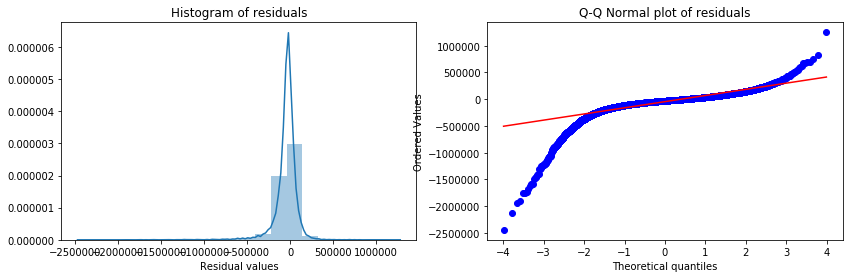

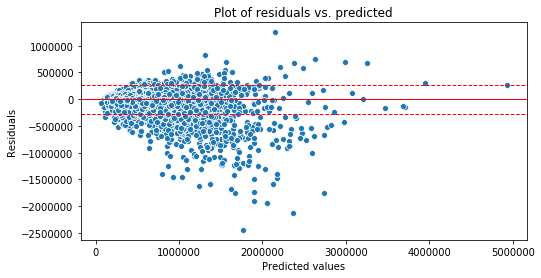

In [50]:
#plot residuals distribution

plot_resid_dist(df_scaled3['resids_lasso'])

residual_plot(df_scaled3, 'predicted_price_lasso_unlogged', 'resids_lasso')

In [51]:
#calculate metrics

ssr3 = sum((df_scaled3['price_log']-df_scaled3['predicted_price_lasso'])**2)       
sst3 = sum((df_scaled3['price_log']-np.mean(df_scaled3['price_log']))**2)    

r_squared3 = 1 - (float(ssr3))/sst3
adjusted_r_squared3 = 1 - (1-r_squared3)*(len(df_scaled3['price_log'])-1)/(len(df_scaled3['price_log'])-df_scaled3[collist2].shape[1]-1)

rmse3 = round(np.sqrt(mean_squared_error(df_scaled3['price'], df_scaled3['predicted_price_lasso_unlogged'])),2)

print('R-Squared: ', np.round(r_squared3,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared3,3))
print('RMSE: ', rmse3)

R-Squared:  0.857
Adj R-Squared:  0.857
RMSE:  142716.44


Analyzing the results, we determine that our model has:
- Adjusted R-square = 0.857
- RMSE: 142,716
- Predicted Mean = 489,629 (v. Actual Mean: 535,286)
- Predicted Standard Dev = 288,020 (v. Actual Standard Dev: 352,005)

#### Linear Model with Elastic Net Regression

In [52]:
#elastic net regression

#df_scaled4 = df_scaled.copy(deep=True)

#y4, X4 = dmatrices(form2, data=df_scaled4)

#for j in ['zipcode']:
#    df_ohe = pd.get_dummies(df_scaled4[j], prefix=j, columns=[j])
#    df_scaled4 = pd.concat([df_ohe, df_scaled4], axis=1)
#    df_scaled4.drop(columns = [j], inplace=True)
        
#ols_model_elastic = sm.OLS(y4, X4).fit_regularized(method = 'elastic_net', alpha=0.001, L1_wt=0.5)

In [53]:
df_scaled4 = df_scaled.copy(deep=True)

ols_model_elastic = smf.ols(form1, data=df_scaled4).fit_regularized(alpha=0.001, L1_wt=0.5)

df_scaled4['predicted_price_elastic'] = ols_model_elastic.predict(df_scaled4.drop(['price_log'], axis=1))

print(df_scaled4[['price_log', 'predicted_price_elastic']])

       price_log  predicted_price_elastic
0      12.309982                12.399534
1      13.195614                13.136095
2      12.100712                12.514813
3      13.311329                13.121503
4      13.142166                13.015027
...          ...                      ...
21608  12.793859                13.167029
21609  12.899220                12.906423
21610  12.904459                12.569255
21611  12.899220                12.939811
21612  12.691580                12.575718

[21138 rows x 2 columns]


In [54]:
df_scaled4['predicted_price_elastic_unlogged'] = np.exp(df_scaled4['predicted_price_elastic'])
df_scaled4['price'] = np.exp(df_scaled4['price_log'])

df_scaled4['resids_elastic'] = np.subtract(df_scaled4['predicted_price_elastic_unlogged'], df_scaled4['price'])

df_scaled4[['price', 'predicted_price_elastic_unlogged', 'resids_elastic']].head()

,price,predicted_price_elastic_unlogged,resids_elastic
0,221900.0,242688.568635,20788.568635
1,538000.0,506913.128974,-31086.871026
2,180000.0,272341.824478,92341.824478
3,604000.0,499570.024261,-104429.975739
4,510000.0,449111.779288,-60888.220712


Mean of predicted values = 516171.0
STD of predicted values = 297821.0



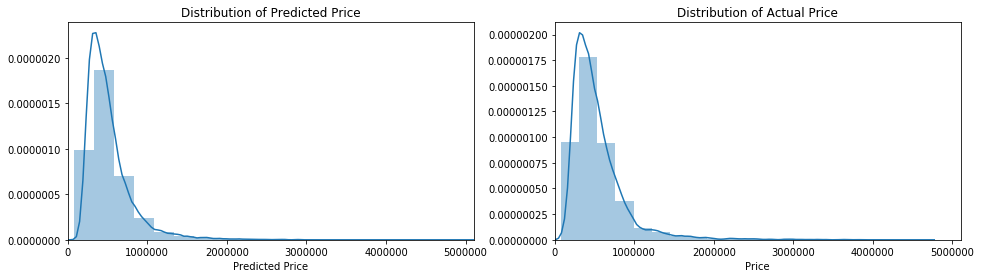

In [55]:
#plot predicted & actual price distributions

xmin = min(min(df_scaled4['predicted_price_elastic_unlogged']), min(df_scaled4['price']))
xmax = max(max(df_scaled4['predicted_price_elastic_unlogged']), max(df_scaled4['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled4['predicted_price_elastic_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled4['predicted_price_elastic_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled4['predicted_price_elastic_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled4['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
_=ax[1].set_xlim(0,xmax)

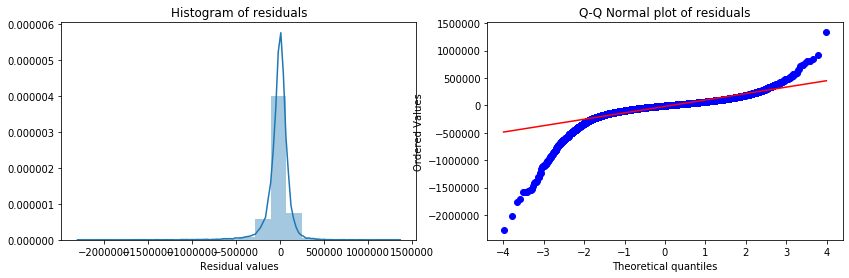

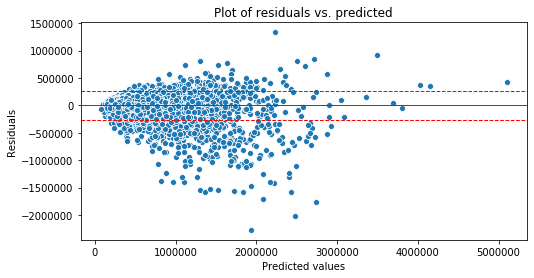

In [56]:
#plot residuals distribution

plot_resid_dist(df_scaled4['resids_elastic'])

residual_plot(df_scaled4, 'predicted_price_elastic_unlogged', 'resids_elastic')

In [57]:
#calculate metrics

ssr4 = sum((df_scaled4['price_log']-df_scaled4['predicted_price_elastic'])**2)       
sst4 = sum((df_scaled4['price_log']-np.mean(df_scaled4['price_log']))**2)    

r_squared4 = 1 - (float(ssr4))/sst4
adjusted_r_squared4 = 1 - (1-r_squared4)*(len(df_scaled4['price_log'])-1)/(len(df_scaled4['price_log'])-df_scaled4[collist2].shape[1]-1)

rmse4 = round(np.sqrt(mean_squared_error(df_scaled4['price'], df_scaled4['predicted_price_elastic_unlogged'])),2)

print('R-Squared: ', np.round(r_squared4,4))
print('Adj R-Squared: ', np.round(adjusted_r_squared4,4))
print('RMSE: ', rmse4)

R-Squared:  0.8597
Adj R-Squared:  0.8597
RMSE:  135228.29


Analyzing the results, we determine that our model has:
- Adjusted R-square = 0.860
- RMSE: 135,228
- Predicted Mean = 516,171 (v. Actual Mean: 535,286)
- Predicted Standard Dev = 297,821 (v. Actual Standard Dev: 352,005)

In [58]:
#compare metrics from four models above

summary = pd.DataFrame(columns = ['Method', 'Mean', 'STD', 'Adj_R2', 'RMSE'])

ols_1 = {'Method': 'Basic LinReg',
             'Mean': np.round(np.mean(df_scaled0['predicted_price_ols']),3),
             'STD': np.round(np.std(df_scaled0['predicted_price_ols']),3),
             'Adj_R2': np.round(adjusted_r_squared0,3),
             'RMSE': rmse0}

ridge = {'Method': 'Ridge',
         'Mean': np.round(np.mean(df_scaled2['predicted_price_ridge_unlogged']),3),
         'STD': np.round(np.std(df_scaled2['predicted_price_ridge_unlogged']),3), 
         'Adj_R2': np.round(adjusted_r_squared2,3), 
         'RMSE': rmse2}

lasso = {'Method': 'Lasso',
         'Mean': np.round(np.mean(df_scaled3['predicted_price_lasso_unlogged']),3),
         'STD': np.round(np.std(df_scaled3['predicted_price_lasso_unlogged']),3),
         'Adj_R2': np.round(adjusted_r_squared3,3),
         'RMSE': rmse3}

elastic = {'Method': 'Elastic',
           'Mean': np.round(np.mean(df_scaled4['predicted_price_elastic_unlogged']),3),
           'STD': np.round(np.std(df_scaled4['predicted_price_elastic_unlogged']),3), 
           'Adj_R2': np.round(adjusted_r_squared4,3), 
           'RMSE': rmse4}

actual = {'Method': 'Actual Data',
          'Mean': np.mean(df['price']),
          'STD': np.std(df['price']),
          'Adj_R2': None,
          'RMSE': None}


summary.loc[0] = actual
summary.loc[1] = ols_1
summary.loc[2] = ridge
summary.loc[3] = lasso
summary.loc[4] = elastic



print('Model Summary')
print(summary.head(6))

Model Summary
         Method          Mean            STD Adj_R2    RMSE
0   Actual Data  535286.50052  352005.322543   None    None
1  Basic LinReg  535286.50100  296013.357000  0.707  190483
2         Ridge  524242.60500  312401.130000  0.883  125009
3         Lasso  489628.70800  288019.692000  0.857  142716
4       Elastic  516171.44400  297821.204000   0.86  135228


Analyzing the model summary above, we determine that the basic OLS model output has the same mean as our original data set, the standard deviation is fairly different. We also notice that the Adjusted R-squared value is just 0.7. 

Comparing the metrics, we determine that adding regularization Ridge Regression to our OLS improves our model. The model gives us mean and standard deviation that are fairly to the actual values. Our model's Adjusted R-squared also improved to 0.883 and our RMSE goes down significantly to 125,009.

When we compare our model using Ridge and models using Lasso or Elastic Net, we determine that the model with Ridge method gives us the best model (highest R-squared and lowest RMSE).

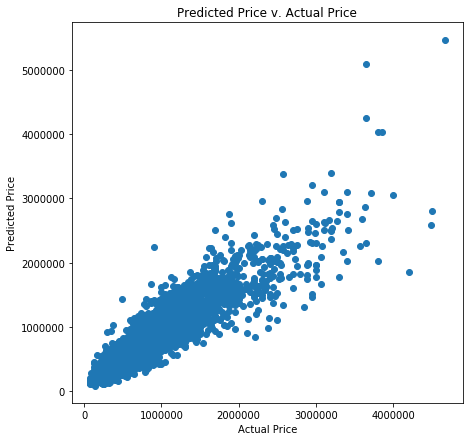

In [59]:
#plot predicted price (ridge) v. actual price

plt.figure(figsize=[7,7])
plt.scatter(y=df_scaled2['predicted_price_ridge_unlogged'], x=df_scaled2['price'])
plt.title('Predicted Price v. Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

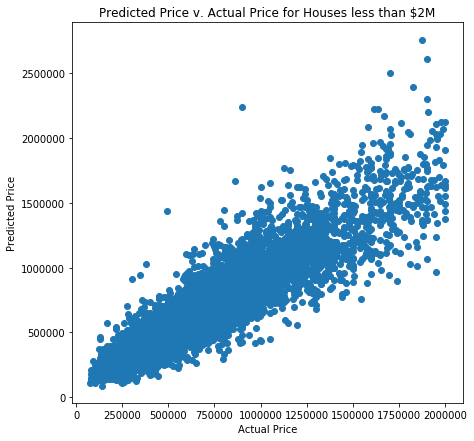

In [60]:
#plot predicted price (ridge) v. actual price

df_less2m = df_scaled2[df_scaled2['price']<=2000000]

plt.figure(figsize=[7,7])
plt.scatter(y=df_less2m['predicted_price_ridge_unlogged'], x=df_less2m['price'])
plt.title('Predicted Price v. Actual Price for Houses less than $2M')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

Analyzing the Prediected v. Actual Price plots above, we determine that our model is fairly good at predicting the houses with actual price lower than $2M. We will calculate the model residuals and analyze them below by plotting the histogram, QQ plot as well as scatter plot.

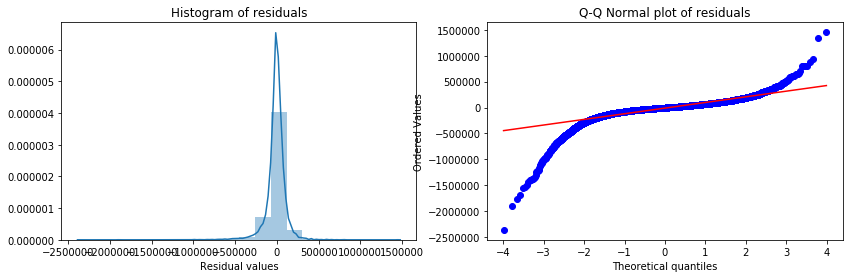

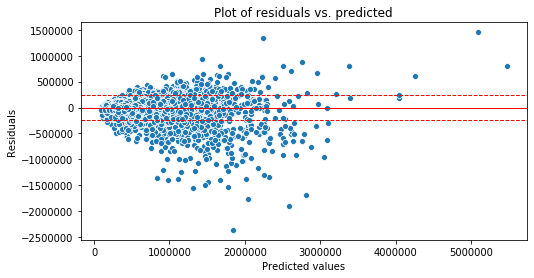

In [61]:
#plot residuals using ridge model

plot_resid_dist(df_scaled2['resids_ridge'])

residual_plot(df_scaled2, 'predicted_price_ridge_unlogged', 'resids_ridge')

Our model's residuals are centered around 0, but have a long left tail. The residuals tend to be lower for houses that are approx. $2M or lower. Based on the QQ plot, our residuals aren't fully normal because towards the tails (both sides), the residuals tend to increase. The residuals are high for more expensive houses. This is a fairly common problem and expected because we have fewer observations for expensive houses (long tail). 